# Small noise approximation - mRNA level

In [1]:
import glob
import pickle
import dill
# Our numerical workhorses
import numpy as np
import scipy.optimize
import scipy.special
import scipy.integrate
import mpmath

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# figdir = '../../fig/chemical_master_analytic_protein/'
tmpdir = '../../tmp/'

### $\LaTeX$ macros

$\newcommand{kpon}{k^p_{\text{on}}}$
$\newcommand{kpoff}{k^p_{\text{off}}}$
$\newcommand{kron}{k^r_{\text{on}}}$
$\newcommand{kroff}{k^r_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{rp}{r _p}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{gp}{\gamma _p}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{pp}{\left\langle p \right\rangle}$
$\newcommand{foldchange}{\text{fold-change}}$

## The small noise approximation.

In this notebook we will explore the use of the small noise approximation in the context of the information processing capacity of the simple repression motif at steady state focusing on the mRNA level.

As derived by Tkacik, Callan and Bialek in their [2008 Phys Rev E paper](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.78.011910), if one assumes the small noise approximation is valid, computing the channel capacity of a genetic regulatory system becomes analytically tractable.
The calculation requires a mapping between the input (in our case $c$ the inducer concentration) and the **mean output** (for this particular notebook the mean protein copy number $\pp$). Since these means are deterministic functions of the input we can use the change of variables
$$
P_c(c) dc = P_{\pp} (\pp) d \pp.
$$
In that case the optimal distribution $P^*_c(c)$ can be mapped to the optimal mean output distribution $P^*_{\pp}(\pp)$.

Using this change of variables and the small noise approximation (SMA) the optimal mean output distribution is given by
$$
P^*(\pp) = {1 \over \mathcal{Z}} {1 \over \sigma_{\pp}(\pp)},
$$
where $\mathcal{Z}$ is a normalization constant of the form
$$
\mathcal{Z} = \int_{\pp _\min}^{\pp _\max} 
              {d\pp \over \sigma_{\pp}\left( \pp \right)}.
$$

Giventhis optimal distribution it can be shown that the channel capacity 
$I^*(c;\pp)$ is given by
$$
I^*(c;\pp) = \log_2 \left( {\mathcal{Z} \over \sqrt{2\pi e}} \right).
$$

So with this amazing and simple result all we need is an expression for the noise $\sigma_{\pp}$ as a function of the mean output $\pp$ in order to compute the channel capacity of our system of interest!

This can be done numerically if we sample over a fine grid of inducer concentration and we compute both the mean $\pp(c)$ and the standard deviation $\sigma(c)$, and given these two results we perform a numerical integration of the resulting one-to-one mapping between these two functions.

## Import `lambdify` functions using `dill`.

When the analytical results were derived we generated `lambdify` functions to explore these results numerically and export them into a file using the `dill` library. Let's now import these functions into this notebook to make use of them.

In [2]:
# Import two-state protein moments
# Parameters are feed in the following order:
# (kp_on, kp_off, rm, gm, rp, gp)
with open(tmpdir + 'two_state_protein_lambdify.dill', 'rb') as file:
    first_unreg_p = dill.load(file)
    second_unreg_p = dill.load(file)
    
# Import two-state protein moments
# Parameters are feed in the following order:
# (kr_on, kr_off, kp_on, kp_off, rm, gm, rp, gp)
with open(tmpdir + 'three_state_protein_lambdify.dill', 'rb') as file:
    first_reg_p = dill.load(file)
    second_reg_p = dill.load(file)

## Integrating the number of repressors into the picture

The way that the repressor copy number enters the kinetic scheme is by assuming that the $\kron$ rate is a diffusion limited rate of the form
$$
\kron = k_o \left[ R \right].
$$
The constant $k_o$ was indirectly inferred by the Sunney Xie lab and quoted by Jones and Brewster as $k_o = 2.7 \times 10^{-3} (\text{s nM})^{-1}$.

The value of $\kroff$ is then constrained by the value of the binding energy as inferred using equilibrium statistical mechanics. For the stat. mech. framework we have that the fold-change in gene expression is given by
$$
\foldchange = \frac{1}{1 + \frac{R \cdot p_{act}}{N_{NS}} e^{-\beta \Delta \epsilon_r}},
$$
where $R$ is the absolute copy number of repressors per cell, $N_{NS}$ is the number of non-specific binding sites for the repressors (in our case the entire *E. coli genome* $4.6 \times 10^6$), $\beta$ is the inverse temperature times the Boltzmann constant and $\Delta \epsilon_r$ is the binding energy of the repressor to the operator binding site.

In the case of the three-state promoter the fold-change is given by
$$
\foldchange = {1 \over 1 + {\kron \over \kroff} 
               \left( {\kpoff \over \kpoff + \kpon} \right)}
            = {1 \over 1 + {k_o [R] p_{act} \over \kroff} 
               \left( {\kpoff \over \kpoff + \kpon} \right)}.
$$

Given that these two equation have the same functional form we can conclude that
$$
\frac{R \cdot p_{act}}{N_{NS}} e^{-\beta \Delta \epsilon_r} =
{k_o [R] p_{act} \over \kroff} 
               \left( {\kpoff \over \kpoff + \kpon} \right).
$$
If we solve for $\kroff$ and convert the absolute number or repressors $R$ into a concentration $[R]$ we find that
$$
\kroff = 1.66 \cdot k_0 \cdot N_{NS} e^{\beta \Delta \epsilon_r}
          \left( {\kpoff \over \kpoff + \kpon} \right).
$$

Given this result let's define a function that computes $\kroff$ as a function of the binding energies and the RNAP rates.

In [3]:
def kr_off_fun(eRA, k0, kp_on, kp_off, Nns=4.6E6):
    '''
    Returns the off rate of the repressor as a function of the stat. mech. 
    binding energy and the RNAP on and off rates
    Parameters
    ----------
    eRA : float.
        Repressor binding energies [kbT]
    k0 : float.
        Diffusion limited constant [s**-1 nM**-1]
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    Nns : float.
        Number of non-specific binding sites
    Returns
    -------
    Repressor off rate
    '''
    return 1.66 * k0 * Nns * np.exp(eRA) * kp_off / (kp_off + kp_on)

Let's now define a function that computes the **mean** $\pp(c)$ and **standard deviation** $\sigma_\pp(c)$ for the regulated promoter as a function of repressor copy number and inducer concentration. For this we will assume that the number of active repressors is given by the equilibrium value as determiend by $R_{act} = R \cdot p_{act}$, where $p_{act}$ is given by the MWC model.

In [5]:
def std_reg_p(C, rep, eRA, rm, gm, rp, gp, k0, kp_on, kp_off, 
                  Nns=4.6E6, ka=139, ki=0.53, epsilon=4.5):
    '''
    Computes the inverse standard deviation in protein copy number 
    as a function  of all the parameters that go into the chemical master 
    equation.
    
    Parameters
    ----------
    C : array-like.
        Concentration at which evaluate the probability.
    rep: float.
        repressor copy number per cell.
    eRA : float.
        Repressor binding energy [kBT]
    rm : float.
        transcription initiation rate. [time**-1]
    gm : float.
        mRNA degradation rate. [time**-1]
    rp : float.
        translation initiation rate. [time**-1]
    gp : float.
        protein degradation rate. [time**-1]
    k0 : float.
        diffusion limited rate of a repressor binding the promoter
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    Nns : float.
        Number of non-specific binding sites
    ki, ka : float.
        dissociation constants for the inactive and active states respectively
        in the MWC model of the lac repressor.
    epsilon : float.
        energetic barrier between the inactive and the active state.
        
    Returns
    -------
    standard deviation in the repressor copy number
    '''
    # Convert C into np.array
    C = np.array(C)
    
    # Calculate the repressor on rate including the MWC model
    kr_on = k0 * rep * chann_cap.p_act(C, ka, ki, epsilon)
    # Compute the repressor off-rate based on the on-rate and the binding energy
    kr_off = kr_off_fun(eRA, k0, kp_on, kp_off, Nns)
    
    return np.sqrt(second_reg_p(kr_on, kr_off, kp_on, kp_off, 
                                rm, gm, rp, gp) - \
                   first_reg_p(kr_on, kr_off, kp_on, kp_off, 
                               rm, gm, rp, gp)**2)


def mean_reg_p(C, rep, eRA, rm, gm, rp, gp, k0, kp_on, kp_off, 
                  Nns=4.6E6, ka=139, ki=0.53, epsilon=4.5):
    '''
    Computes the mean protein copy number  as a function  of all the 
    parameters that go into the chemical master equation.
    
    Parameters
    ----------
    C : array-like.
        Concentration at which evaluate the probability.
    rep: float.
        repressor copy number per cell.
    eRA : float.
        Repressor binding energy [kBT]
    rm : float.
        transcription initiation rate. [time**-1]
    gm : float.
        mRNA degradation rate. [time**-1]
    rp : float.
        translation initiation rate. [time**-1]
    gp : float.
        protein degradation rate. [time**-1]
    k0 : float.
        diffusion limited rate of a repressor binding the promoter
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    Nns : float.
        Number of non-specific binding sites
    ki, ka : float.
        dissociation constants for the inactive and active states respectively
        in the MWC model of the lac repressor.
    epsilon : float.
        energetic barrier between the inactive and the active state.
        
    Returns
    -------
    mean mRNA copy number
    '''
    # Convert C into np.array
    C = np.array(C)
    
    # Calculate the repressor on rate including the MWC model
    kr_on = k0 * rep * chann_cap.p_act(C, ka, ki, epsilon)
    # Compute the repressor off-rate based on the on-rate and the binding energy
    kr_off = kr_off_fun(eRA, k0, kp_on, kp_off, Nns)
    
    return first_reg_p(kr_on, kr_off, kp_on, kp_off, rm, gm, rp, gp)

Let's now evaluate both functions for a grid of inducer concentrations and plot mean vs inverse standard deviation.

First let's define the parameters for the *lacUV5* promoter.

In [6]:
# List the parameters fit for the lacUV5 promoter
par_UV5 = dict(kp_on=5.5, kp_off=28.9, rm=87.6, gm=1)
# Define the k0 parameters in units of the mRNA degradation time
k0_norm = 2.7E-3 / 0.00284 
par_UV5['k0'] = k0_norm

# define protein degradation rate in units of mRNA degradation rate
gp = 0.000277 / 0.00284 
par_UV5['gp'] = gp

# define rp based on the mean protein copy number per mRNA
par_UV5['rp'] = 1000 * par_UV5['gp']

Now let's define the parameters for different operators with 260 repressors per cell.

(0, 0.0068949281978496835)

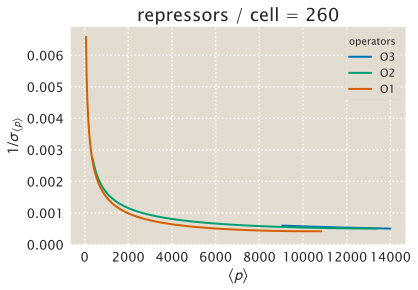

In [8]:
# Define grid of inducer concentrations
IPTG = np.logspace(-1, 8, 1000)
# Copy parameter list
par = par_UV5.copy()
# Add binding energy and repressor copy number
par['rep'] = 260

# Define energies of different operators
operators = ['O3', 'O2', 'O1']
energies = [-9.7, -13.9, -15.7]

# Loop through energies
for i, op in enumerate(operators):
    par['eRA'] = energies[i]

    mean_m = mean_reg_p(IPTG, **par)
    std_m = std_reg_p(IPTG, **par)

    plt.plot(mean_m, 1 / std_m, label=op)
    
plt.xlabel(r'$\left\langle p \right\rangle$')
plt.ylabel(r'$1 / \sigma_{\left\langle p \right\rangle}$')
plt.title('repressors / cell = 260')
plt.legend(title='operators')
plt.ylim(bottom=0)

Let's do it instead for varying number of repressors

(0, 0.0072984237603883799)

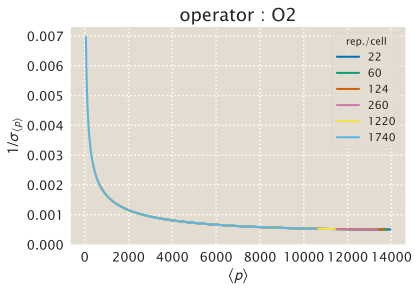

In [9]:
# Define grid of inducer concentrations
IPTG = np.logspace(-1, 8, 1000)
# Copy parameter list
par = par_UV5.copy()
# Add binding energy and repressor copy number
par['eRA'] = -13.9

# Define the repressor copy numbers to use
repressors = [22, 60, 124, 260, 1220, 1740]

# Loop through repressors
for rep in repressors:
    par['rep'] = rep

    mean_m = mean_reg_p(IPTG, **par)
    std_m = std_reg_p(IPTG, **par)

    plt.plot(mean_m, 1 / std_m, label=rep)
    
plt.xlabel(r'$\left\langle p \right\rangle$')
plt.ylabel(r'$1 / \sigma_{\left\langle p \right\rangle}$')
plt.title('operator : O2')
plt.legend(title='rep./cell')
plt.ylim(bottom=0)

# Compute the channel capacity from this sampling.

Now that we can numerically evaluate the noise in gene expression as a function of the mean expression level, let's use numerical integration to compute $\mathcal{Z}$ defined as
$$
\mathcal{Z} = \int_{\mm _\min}^{\mm _\max} 
              {d\mm \over \sigma_{\mm}\left( \mm \right)}.
$$
To then compute the channel capacity defined as
$I^*(c;\mm)$ is given by
$$
I^*(c;\mm) = \log_2 \left( {\mathcal{Z} \over \sqrt{2\pi e}} \right).
$$

Let's define a function to compute this.

In [11]:
def chann_cap_SMA_p(C, rep, eRA, rm, gm, rp, gp, k0, kp_on, kp_off, 
                    Nns=4.6E6, ka=139, ki=0.53, epsilon=4.5):
    '''
    Computes the channel capacity (in bits) using the 
    small noise approximation as a function  of all the parameters 
    that go into the chemical master equation.
    
    Parameters
    ----------
    C : array-like.
        Concentration at which evaluate the probability.
    rep: float.
        repressor copy number per cell.
    eRA : float.
        Repressor binding energy [kBT]
    rm : float.
        transcription initiation rate. [time**-1]
    gm : float.
        mRNA degradation rate. [time**-1]
    rp : float.
        translation initiation rate. [time**-1]
    gp : float.
        protein degradation rate. [time**-1]
    k0 : float.
        diffusion limited rate of a repressor binding the promoter
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    Nns : float.
        Number of non-specific binding sites
    ki, ka : float.
        dissociation constants for the inactive and active states respectively
        in the MWC model of the lac repressor.
    epsilon : float.
        energetic barrier between the inactive and the active state.
        
    Returns
    -------
    maximum number of bits that the system can process
    '''
    # Compute the mean number of mRNA for the inducer grid
    mean_p = mean_reg_p(C, rep, eRA, rm, gm, rp, gp, k0, kp_on, kp_off, 
                        Nns, ka, ki, epsilon)
    
    # Compute the std of mRNA for the inducer grid
    std_p = std_reg_p(C, rep, eRA, rm, gm, rp, gp, k0, kp_on, kp_off, 
                      Nns, ka, ki, epsilon)
    
    # Compute Z
    Z = scipy.integrate.simps(1 / std_p, mean_p)
    
    return np.log2(Z / np.sqrt(2 * np.pi * np.e))

Let's now look at the channel capacity as a function of repressor copy number

(0, 1.8047785720653513)

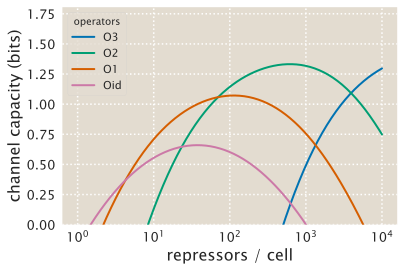

In [19]:
# Define grid of repressor copy number
rep_array = np.logspace(0, 4, 200)

# Define grid of inducer concentrations
IPTG = np.logspace(-1, 8, 2000)
# Copy parameter list
par = par_UV5.copy()

# Define energies of different operators
operators = ['O3', 'O2', 'O1', 'Oid']
energies = [-9.7, -13.9, -15.7, -17]

# Loop through energies
for j, eRA in enumerate(energies):
    # Add binding energy and repressor copy number
    par['eRA'] = eRA
    # Initialize array to save channel capacity
    channel_cap = np.zeros_like(rep_array)
    # Loop through repressor copy number computing the channel capacity
    for i, rep in enumerate(rep_array):
        par['rep'] = rep
        channel_cap[i] = chann_cap_SMA_p(IPTG, **par)
    
    # Plot repressors vs channel capacity
    plt.plot(rep_array, channel_cap, label=operators[j])

plt.xlabel('repressors / cell')
plt.ylabel('channel capacity (bits)')
plt.legend(title='operators')
plt.xscale('log')
plt.ylim(bottom=0)